# Exploring the effects of filtering on Radiomics features

In this notebook, we will explore how different filters change the radiomics features.

In [1]:
# Radiomics package
from radiomics import featureextractor

import six, numpy as np

## Setting up data

Here we use `SimpleITK` (referenced as `sitk`, see http://www.simpleitk.org/ for details) to load an image and the corresponding segmentation label map.

In [2]:
import os
import SimpleITK as sitk

from radiomics import getTestCase

# repositoryRoot points to the root of the repository. The following line gets that location if this Notebook is run
# from it's default location in \pyradiomics\examples\Notebooks
repositoryRoot = os.path.abspath(os.path.join(os.getcwd(), ".."))

imagepath, labelpath = getTestCase('brain1', repositoryRoot)

image = sitk.ReadImage(imagepath)
label = sitk.ReadImage(labelpath)

## Show the images

Using `matplotlib.pyplot` (referenced as `plt`), display the images in grayscale and labels in color.

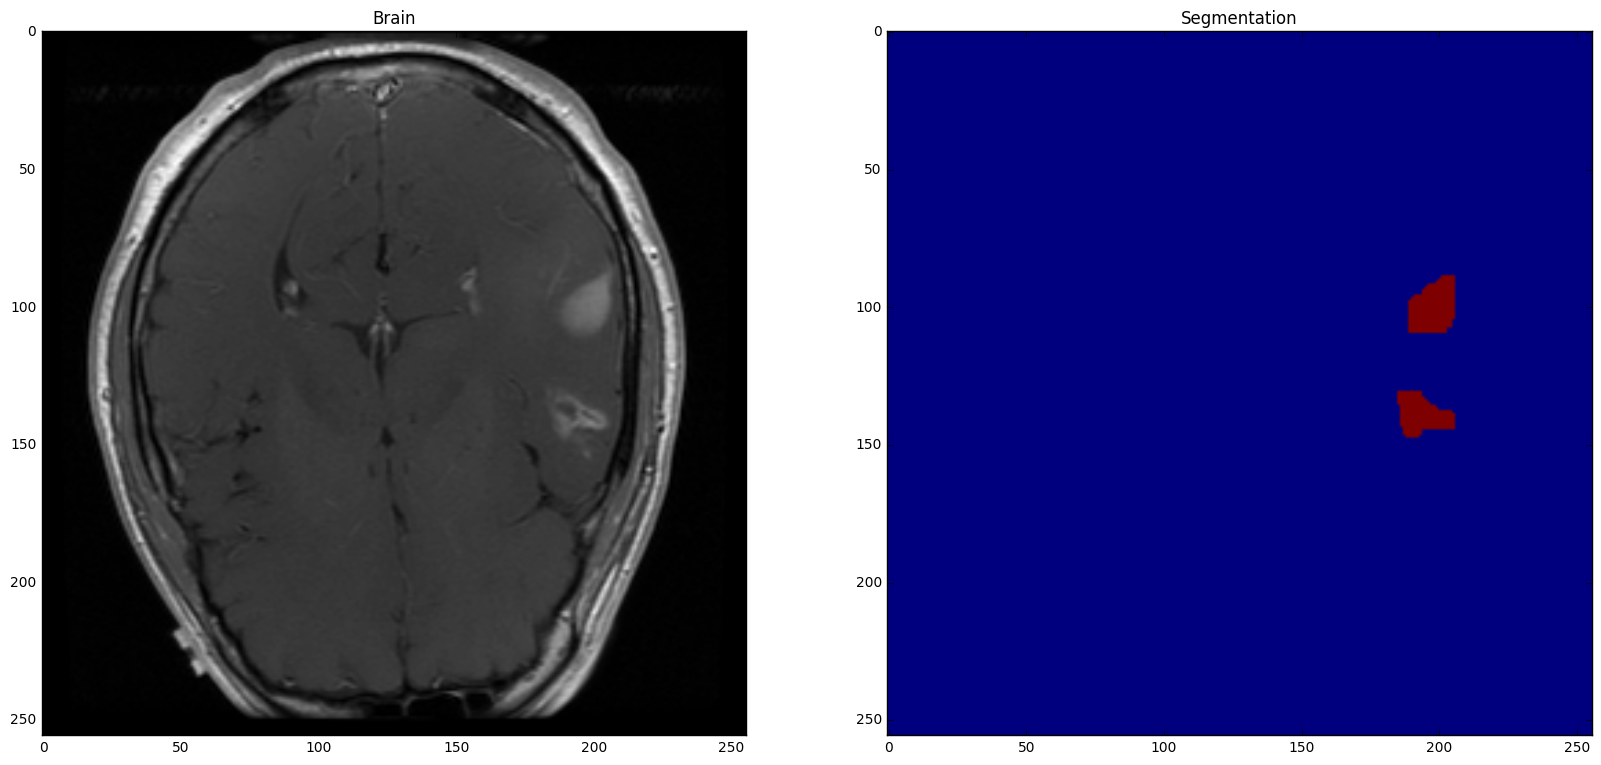

In [3]:
# Display the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
# First image
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap="gray")
plt.title("Brain")
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(label)[12,:,:])        
plt.title("Segmentation")

plt.show()

## Extract the features

Using the `radiomics` package, first construct an `extractor` object from the parameters set in `Params.yaml`.  We will then generate a baseline set of features.  Comparing the features after running `SimpleITK` filters will show which features are less sensitive.

In [4]:
import os
# Instantiate the extractor
params = os.path.join(os.getcwd(), '..', 'examples', 'exampleSettings', 'Params.yaml')

extractor = featureextractor.RadiomicsFeatureExtractor(params)
extractor.enableFeatureClassByName('shape', enabled=False)  # disable shape as it is independent of gray value
# Construct a set of SimpleITK filter objects
filters = {
    "AdditiveGaussianNoise" : sitk.AdditiveGaussianNoiseImageFilter(),
    "Bilateral" : sitk.BilateralImageFilter(),
    "BinomialBlur" : sitk.BinomialBlurImageFilter(),
    "BoxMean" : sitk.BoxMeanImageFilter(),
    "BoxSigmaImageFilter" : sitk.BoxSigmaImageFilter(),
    "CurvatureFlow" : sitk.CurvatureFlowImageFilter(),
    "DiscreteGaussian" : sitk.DiscreteGaussianImageFilter(),
    "LaplacianSharpening" : sitk.LaplacianSharpeningImageFilter(),
    "Mean" : sitk.MeanImageFilter(),
    "Median" : sitk.MedianImageFilter(),
    "Normalize" : sitk.NormalizeImageFilter(),
    "RecursiveGaussian" : sitk.RecursiveGaussianImageFilter(),
    "ShotNoise" : sitk.ShotNoiseImageFilter(),
    "SmoothingRecursiveGaussian" : sitk.SmoothingRecursiveGaussianImageFilter(),
    "SpeckleNoise" : sitk.SpeckleNoiseImageFilter(),
}

In [5]:
# Filter
results = {}

results["baseline"] = extractor.execute(image, label)

for key, value in six.iteritems(filters):
    print ( "filtering with " + key )
    filtered_image = value.Execute(image)
    results[key] = extractor.execute(filtered_image, label)

filtering with BinomialBlur
filtering with Normalize
filtering with LaplacianSharpening
filtering with Bilateral
filtering with SpeckleNoise
filtering with Median
filtering with ShotNoise
filtering with RecursiveGaussian
filtering with AdditiveGaussianNoise
filtering with Mean
filtering with SmoothingRecursiveGaussian
filtering with BoxSigmaImageFilter
filtering with BoxMean
filtering with CurvatureFlow
filtering with DiscreteGaussian


## Prepare for analysis

Determine which features had the highest variance.

In [6]:
# Keep an index of filters and features
filter_index = list(sorted(filters.keys()))
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), results[filter_index[0]] )))

## Look at the features with highest and lowest coefficient of variation

The [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) gives a standardized measure of dispersion in a set of data.  Here we look at the effect of filtering on the different features.

**Spoiler alert** As might be expected, the grey level based features, e.g. `ClusterShade`, `LargeAreaEmphasis`, etc. are most affected by filtering, and shape metrics (based on label mask only) are the least affected.

In [7]:
# Pull in scipy to help find cv
import scipy.stats

features = {}
cv = {}

for key in feature_names:
    a = np.array([])
    for f in filter_index:
        a = np.append(a, results[f][key])
    features[key] = a
    cv[key] = scipy.stats.variation(a)
    
# a sorted view of cv
cv_sorted = sorted(cv, key=cv.get, reverse=True)

# Print the top 10
print ("\n")
print ("Top 10 features with largest coefficient of variation")
for i in range(0,10):
    print ("Feature: {:<50} CV: {}".format ( cv_sorted[i], cv[cv_sorted[i]]))
    
print ("\n")
print ("Bottom 10 features with _smallest_ coefficient of variation")
for i in range(-11,-1):
    print ("Feature: {:<50} CV: {}".format ( cv_sorted[i], cv[cv_sorted[i]]))



Top 10 features with largest coefficient of variation
Feature: original_glszm_LargeAreaLowGrayLevelEmphasis       CV: 3.74154286832
Feature: original_glszm_LargeAreaEmphasis                   CV: 3.738220118
Feature: original_glcm_ClusterShade                         CV: 3.73649447405
Feature: original_glszm_ZoneVariance                        CV: 3.73227185219
Feature: original_glcm_ClusterProminence                    CV: 3.72000531316
Feature: original_glrlm_LongRunLowGrayLevelEmphasis         CV: 3.71999298065
Feature: original_gldm_LargeDependenceLowGrayLevelEmphasis  CV: 3.66052640528
Feature: original_glszm_LargeAreaHighGrayLevelEmphasis      CV: 3.52751618557
Feature: original_glcm_JointEnergy                          CV: 3.37350700734
Feature: original_glcm_DifferenceVariance                   CV: 3.34992406752


Bottom 10 features with _smallest_ coefficient of variation
Feature: original_glcm_SumEntropy                           CV: 0.302340136092
Feature: original_glrlm_R